In [78]:
import json
import os 
from path import Path
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import keras



In [3]:
planes_path = Path(r'C:\Users\Bugra\Documents\GitHub\CNN_planes\data\Planes\planesnet\planesnet\planesnet')


In order to represent number of images with label we have take first element of file name.

In [4]:
planes = []

all_planes = os.listdir(planes_path)
for ac in all_planes:
    planes.append((ac[0],str(planes_path)+"/"+str(ac)))

# Build a dataframe        
planes = pd.DataFrame(data=planes, columns=['label','image_path'], index=None)
planes.sample(5)

,label,image_path
31305,1,C:\Users\Bugra\Documents\GitHub\CNN_planes\dat...
31301,1,C:\Users\Bugra\Documents\GitHub\CNN_planes\dat...
11115,0,C:\Users\Bugra\Documents\GitHub\CNN_planes\dat...
20374,0,C:\Users\Bugra\Documents\GitHub\CNN_planes\dat...
28923,1,C:\Users\Bugra\Documents\GitHub\CNN_planes\dat...


Total Number of planes imgs in dataset :  32000


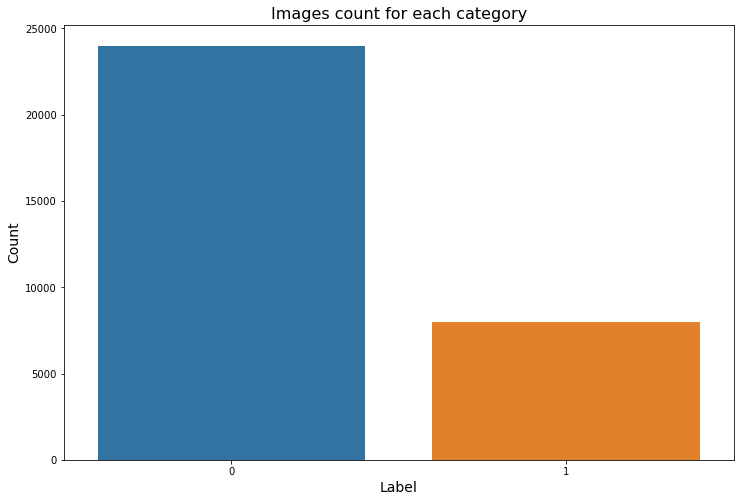

In [5]:
print("Total Number of planes imgs in dataset : ", len(planes))
ac_count = planes['label'].value_counts()
plt.figure(figsize=(12,8))
sns.barplot(x=ac_count.index, y=ac_count.values)
plt.title("Images count for each category", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

Our dataset mostly consist of  images without plane, resampling or in our case Data Augmentation is required.

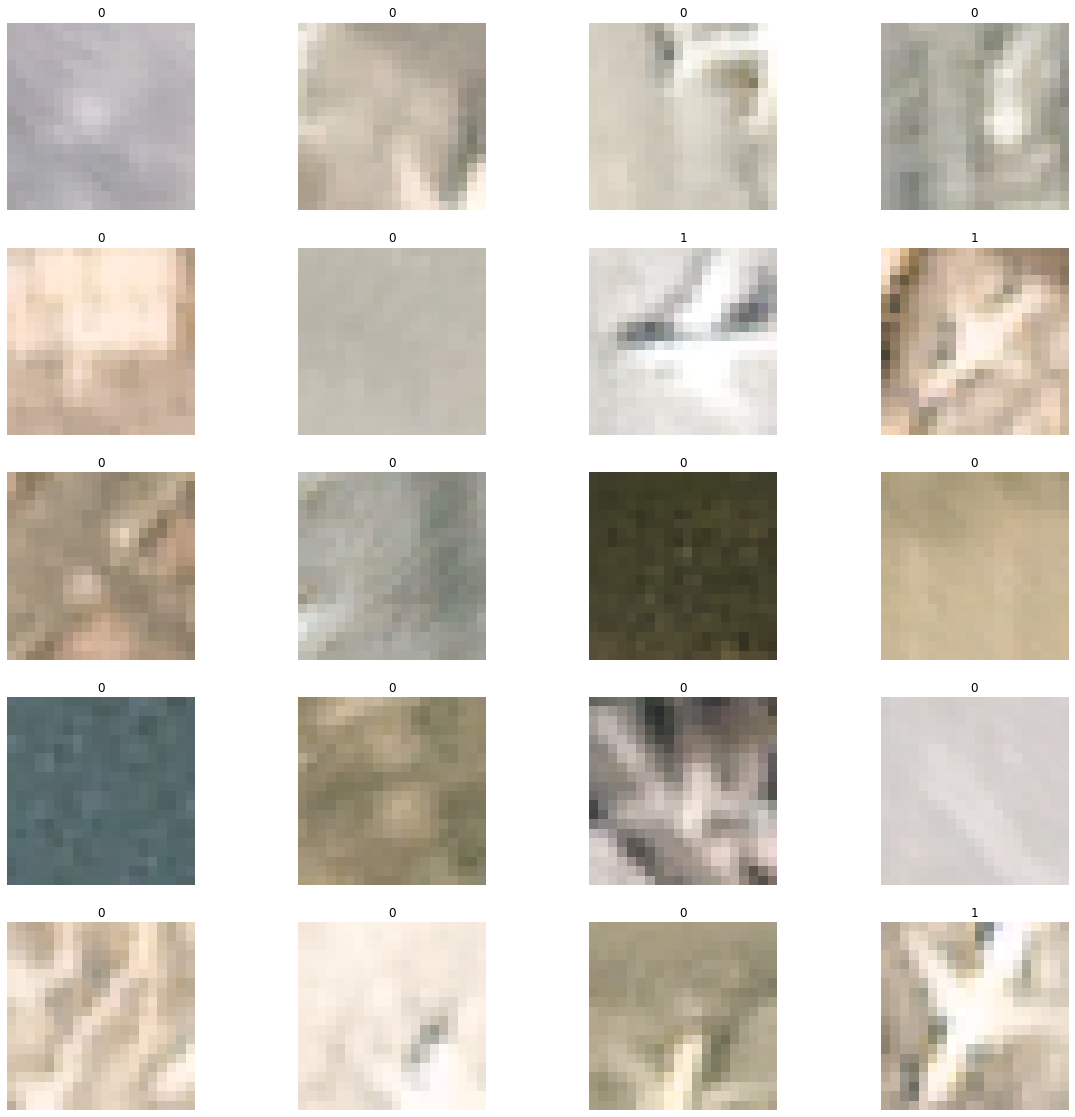

In [6]:
random_samples = []

for item in planes.sample(20).iterrows():
    random_samples.append((item[1].label, item[1].image_path))

f, ax = plt.subplots(5,4, figsize=(20,20))
for i,sample in enumerate(random_samples):
    ax[i//4, i%4].imshow(plt.imread(random_samples[i][1]))
    ax[i//4, i%4].set_title(random_samples[i][0])
    ax[i//4, i%4].axis('off')
plt.show() 

In [7]:
f = open(r'C:\Users\Bugra\Documents\GitHub\CNN_planes\data\Planes\planesnet\planesnet.json')
planesnet = json.load(f)
f.close()

In [110]:
X = np.array(planesnet["data"]) / 255.
X = X.reshape([-1,3,20,20]).transpose([0,2,3,1])
Y = np.array(planesnet['labels'])
Y = tf.keras.utils.to_categorical(Y, 2)

Let`s make sure data is scale by looking min and max value.

In [9]:
print(np.min(X[0]),np.max(X[0]))


0.38823529411764707 1.0


Let`s divide dataset to train and test 80% of train 20% of test.

In [113]:
from sklearn.model_selection import train_test_split
x_train , x_test, y_train,y_test = train_test_split(X,Y,test_size=.20,random_state=42,shuffle=True)


In [133]:
print('Training data shape : ', x_train.shape, y_train.shape)

print('Testing data shape : ', x_test.shape, y_test.shape)

Training data shape :  (25600, 20, 20, 3) (25600, 2)
Testing data shape :  (6400, 20, 20, 3) (6400, 2)


In [55]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU ,ReLU
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tflearn.data_augmentation import ImageAugmentation

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


With Create_model function we have defined our base model with 2 hidden layer, using 2 by 2 kernel and pooling again by 2 by 2. We are using padding same as we do not want to lose any pixel.

In [135]:
def Create_model():
    model = Sequential()#Create our Model
    #First Layer
    model.add(Conv2D(16,(2,2),input_shape=(20,20,3),padding='same',activation='relu')) #first layer of our network
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))

    #Second Layer
    model.add(Conv2D(32,(2,2),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))



    #Flatten
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['binary_accuracy'])
    return model
    

Base Model

In [136]:
base = Create_model()


In [137]:
batch_size = 16
epochs = 20
model = base.fit(x_train,y_train,batch_size=batch_size,epochs =epochs)


Train on 25600 samples
Epoch 1/20
25600/25600 [==============================] - 4s 141us/sample - loss: 0.2594 - binary_accuracy: 0.8907
Epoch 2/20
25600/25600 [==============================] - 4s 138us/sample - loss: 0.1499 - binary_accuracy: 0.9412
Epoch 3/20
25600/25600 [==============================] - 4s 145us/sample - loss: 0.1290 - binary_accuracy: 0.9515
Epoch 4/20
25600/25600 [==============================] - 4s 137us/sample - loss: 0.1184 - binary_accuracy: 0.9554
Epoch 5/20
25600/25600 [==============================] - 4s 140us/sample - loss: 0.1104 - binary_accuracy: 0.9572
Epoch 6/20
25600/25600 [==============================] - 4s 140us/sample - loss: 0.1065 - binary_accuracy: 0.9586
Epoch 7/20
25600/25600 [==============================] - 4s 138us/sample - loss: 0.1032 - binary_accuracy: 0.9614
Epoch 8/20
25600/25600 [==============================] - 4s 139us/sample - loss: 0.0973 - binary_accuracy: 0.9617
Epoch 9/20
25600/25600 [==============================] -

In [265]:
from statistics import mean
mean(model.history['binary_accuracy'])

0.9597812

Base model average accuracy is .9597 which is not bad, in order to keep track of models we will store test accuracies in model_scores dictionary.

In [150]:

score, acc = base.evaluate(x_test, y_test, verbose = 0)
print(score,acc)
model_scores = {}
model_scores['Base']=acc

0.09154798446921632 0.96835935


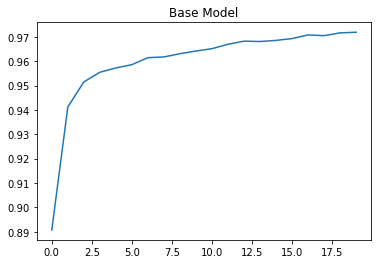

In [141]:
plt.plot(model.history['binary_accuracy'])
plt.title('Base Model')
plt.show()


In order to observe the difference we will use the same model with 50 epochs which in theory should perform better as model will train more with 50 epochs.

In [142]:
epoch_model = Create_model()
batch_size = 16
epochs = 50
mod_1 = epoch_model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)

Train on 25600 samples
Epoch 1/50
25600/25600 [==============================] - 4s 143us/sample - loss: 0.2966 - binary_accuracy: 0.8738
Epoch 2/50
25600/25600 [==============================] - 4s 146us/sample - loss: 0.1748 - binary_accuracy: 0.9311
Epoch 3/50
25600/25600 [==============================] - 4s 143us/sample - loss: 0.1492 - binary_accuracy: 0.9431
Epoch 4/50
25600/25600 [==============================] - 4s 145us/sample - loss: 0.1348 - binary_accuracy: 0.9479
Epoch 5/50
25600/25600 [==============================] - 4s 143us/sample - loss: 0.1308 - binary_accuracy: 0.9492
Epoch 6/50
25600/25600 [==============================] - 4s 146us/sample - loss: 0.1221 - binary_accuracy: 0.9527
Epoch 7/50
25600/25600 [==============================] - 4s 147us/sample - loss: 0.1184 - binary_accuracy: 0.9546
Epoch 8/50
25600/25600 [==============================] - 4s 150us/sample - loss: 0.1136 - binary_accuracy: 0.9571
Epoch 9/50
25600/25600 [==============================] -

In [267]:
mean(mod_1.history['binary_accuracy'])

0.96335393

In [152]:
score_epoc, acc_epoc =epoch_model.evaluate(x_test,y_test,verbose=0)
print(score_epoc,acc_epoc)
model_scores['Epoch'] = acc_epoc

0.09417683418781962 0.96625


As we guessed our second model perform better on train dataset, increasing by 1 point.However increasing epochs did not help our test performence.

No handles with labels found to put in legend.


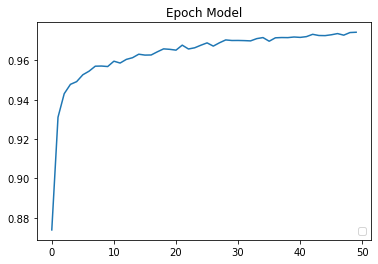

In [268]:

plt.plot(mod_1.history['binary_accuracy'])
plt.title('Epoch Model')
plt.legend(loc='lower right')
plt.show()



In [154]:
mod2 = Create_model()
batch_size=32
epochs=50
batch_mod = mod2.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)

Train on 25600 samples
Epoch 1/50
25600/25600 [==============================] - 3s 108us/sample - loss: 0.2887 - binary_accuracy: 0.8789
Epoch 2/50
25600/25600 [==============================] - 3s 100us/sample - loss: 0.1592 - binary_accuracy: 0.9380
Epoch 3/50
25600/25600 [==============================] - 3s 104us/sample - loss: 0.1320 - binary_accuracy: 0.9486
Epoch 4/50
25600/25600 [==============================] - 3s 98us/sample - loss: 0.1179 - binary_accuracy: 0.9550
Epoch 5/50
25600/25600 [==============================] - 3s 99us/sample - loss: 0.1121 - binary_accuracy: 0.9564
Epoch 6/50
25600/25600 [==============================] - 3s 100us/sample - loss: 0.1070 - binary_accuracy: 0.9596
Epoch 7/50
25600/25600 [==============================] - 3s 101us/sample - loss: 0.1006 - binary_accuracy: 0.9628
Epoch 8/50
25600/25600 [==============================] - 3s 111us/sample - loss: 0.0991 - binary_accuracy: 0.9632
Epoch 9/50
25600/25600 [==============================] - 3

In [269]:
mean(batch_mod.history['binary_accuracy'])

0.96969885

In [155]:
score_batch , acc_batch =mod2.evaluate(x_test,y_test,verbose=0)
model_scores['Batch1'] = acc_batch

Keeping epochs same and incresing batch size increased the mean train accuracy to highest till now. This tweak also increased our test accuracy by one point.

No handles with labels found to put in legend.


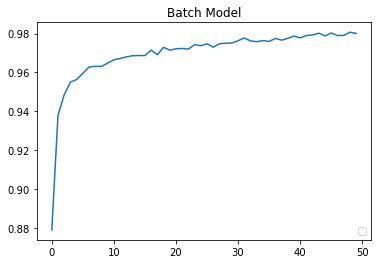

In [156]:
plt.plot(batch_mod.history['binary_accuracy'])
plt.title('Batch Model')
plt.legend(loc='lower right')
plt.show()

In [157]:
def kernel_model():


    model = Sequential()#Create our Model
    #First Layer
    model.add(Conv2D(16,(3,3),input_shape=(20,20,3),padding='same',activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))

    #Second Layer
    model.add(Conv2D(32,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))



    #Flatten
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['binary_accuracy'])
    return model
    

In [158]:
mod3 = kernel_model()
batch_size = 16
epochs = 20
_kernel_model = mod3.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)

Train on 25600 samples
Epoch 1/20
25600/25600 [==============================] - 5s 204us/sample - loss: 0.2302 - binary_accuracy: 0.9044
Epoch 2/20
25600/25600 [==============================] - 5s 192us/sample - loss: 0.1395 - binary_accuracy: 0.9481
Epoch 3/20
25600/25600 [==============================] - 5s 188us/sample - loss: 0.1176 - binary_accuracy: 0.9560
Epoch 4/20
25600/25600 [==============================] - 5s 195us/sample - loss: 0.1062 - binary_accuracy: 0.9600
Epoch 5/20
25600/25600 [==============================] - 5s 194us/sample - loss: 0.0993 - binary_accuracy: 0.9627
Epoch 6/20
25600/25600 [==============================] - 5s 194us/sample - loss: 0.0916 - binary_accuracy: 0.9647
Epoch 7/20
25600/25600 [==============================] - 5s 194us/sample - loss: 0.0860 - binary_accuracy: 0.9665
Epoch 8/20
25600/25600 [==============================] - 5s 195us/sample - loss: 0.0800 - binary_accuracy: 0.9701
Epoch 9/20
25600/25600 [==============================] -

In [275]:
mean(_kernel_model.history['binary_accuracy']) 


0.967998

In [159]:
score_kernel , acc_kernel =mod3.evaluate(x_test,y_test,verbose=0)
model_scores['Kernel'] = acc_kernel

Incresing kernel size did not help to improve accuracy rate.

No handles with labels found to put in legend.


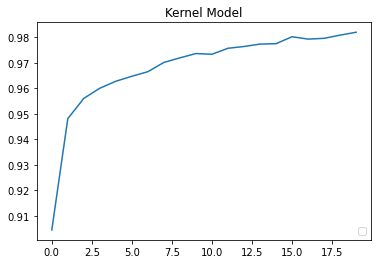

In [160]:
plt.plot(_kernel_model.history['binary_accuracy'])
plt.title('Kernel Model')
plt.legend(loc='lower right')
plt.show()

In [161]:
mod_4 = kernel_model()
batch_size =32
epochs = 50
batch_epoch = mod_4.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)

Train on 25600 samples
Epoch 1/50
25600/25600 [==============================] - 3s 132us/sample - loss: 0.2577 - binary_accuracy: 0.8921
Epoch 2/50
25600/25600 [==============================] - 3s 124us/sample - loss: 0.1489 - binary_accuracy: 0.9423
Epoch 3/50
25600/25600 [==============================] - 3s 129us/sample - loss: 0.1226 - binary_accuracy: 0.9532
Epoch 4/50
25600/25600 [==============================] - 3s 128us/sample - loss: 0.1116 - binary_accuracy: 0.9571
Epoch 5/50
25600/25600 [==============================] - 3s 125us/sample - loss: 0.1048 - binary_accuracy: 0.9594
Epoch 6/50
25600/25600 [==============================] - 3s 128us/sample - loss: 0.0952 - binary_accuracy: 0.9637
Epoch 7/50
25600/25600 [==============================] - 3s 129us/sample - loss: 0.0932 - binary_accuracy: 0.9655
Epoch 8/50
25600/25600 [==============================] - 3s 127us/sample - loss: 0.0866 - binary_accuracy: 0.9673
Epoch 9/50
25600/25600 [==============================] -

In [277]:
mean(batch_epoch.history['binary_accuracy'])

0.97787654

In [164]:
score_krnl2 , acc_kernel2 = mod_4.evaluate(x_test,y_test,verbose=0)
model_scores['Kernel_2'] = acc_kernel2

Keeping the same kernel size and updateing the batch and epoch to 32 , 50 drops the accuracy slightly

No handles with labels found to put in legend.


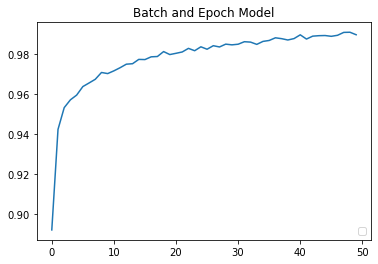

In [165]:
plt.plot(batch_epoch.history['binary_accuracy'])
plt.title('Batch and Epoch Model')
plt.legend(loc='lower right')
plt.show()

,Base,Epoch,Batch1,Kernel,Kernel_2,Leru,Early,Early and Drop,Sgd,Sgd with Sigmoid
0,0.968359,0.96625,0.976484,0.973125,0.970469,0.975156,0.97625,0.973437,0.948438,0.969141


In [166]:
def leru_model():

    model = Sequential()#Create our Model
    #First Layer
    model.add(Conv2D(16,(3,3),input_shape=(20,20,3),padding='same'))
    model.add(LeakyReLU(alpha=.2)) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))

    #Second Layer
    model.add(Conv2D(32,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=.2)) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))



    #Flatten
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['binary_accuracy'])
    return model

Instead of Relu activation function let`s try with Leru and see the result.

In [167]:
mod_5 = leru_model()
batch_size =32
epochs=50
base_kernel_leru = mod_5.fit(x_train,y_train,epochs=epochs,batch_size=batch_size)

Train on 25600 samples
Epoch 1/50
25600/25600 [==============================] - 4s 137us/sample - loss: 0.2858 - binary_accuracy: 0.8765
Epoch 2/50
25600/25600 [==============================] - 3s 136us/sample - loss: 0.1523 - binary_accuracy: 0.9409
Epoch 3/50
25600/25600 [==============================] - 4s 137us/sample - loss: 0.1253 - binary_accuracy: 0.9518
Epoch 4/50
25600/25600 [==============================] - 3s 133us/sample - loss: 0.1126 - binary_accuracy: 0.9569
Epoch 5/50
25600/25600 [==============================] - 4s 140us/sample - loss: 0.1003 - binary_accuracy: 0.9620
Epoch 6/50
25600/25600 [==============================] - 4s 140us/sample - loss: 0.0930 - binary_accuracy: 0.9638
Epoch 7/50
25600/25600 [==============================] - 4s 142us/sample - loss: 0.0879 - binary_accuracy: 0.9674
Epoch 8/50
25600/25600 [==============================] - 4s 140us/sample - loss: 0.0794 - binary_accuracy: 0.9703
Epoch 9/50
25600/25600 [==============================] -

In [281]:
mean(base_kernel_leru.history['binary_accuracy'])


,Base,Epoch,Batch1,Kernel,Kernel_2,Leru,Early,Early and Drop,Sgd,Sgd with Sigmoid
0,0.968359,0.96625,0.976484,0.973125,0.970469,0.975156,0.97625,0.973437,0.948438,0.969141


With Leru function we have achieved the second best model till now.

In [168]:
score_leru , acc_leru = mod_5.evaluate(x_test,y_test,verbose=0)
model_scores['Leru'] = acc_leru

No handles with labels found to put in legend.


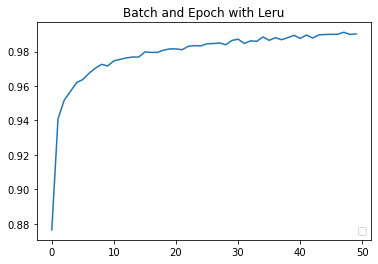

In [271]:
plt.plot(base_kernel_leru.history['binary_accuracy'])
plt.title('Batch and Epoch with Leru')
plt.legend(loc='lower right')
plt.show()

In [186]:
from keras.callbacks import EarlyStopping

early_callback = EarlyStopping(monitor='binary_accuracy',patience= 3)
mod_6 = leru_model()
batch_size =32
epochs=50
early_model = mod_6.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,callbacks=[early_callback])

Train on 25600 samples
Epoch 1/50
25600/25600 [==============================] - 4s 140us/sample - loss: 0.2742 - binary_accuracy: 0.8854
Epoch 2/50
25600/25600 [==============================] - 4s 139us/sample - loss: 0.1502 - binary_accuracy: 0.9406
Epoch 3/50
25600/25600 [==============================] - 4s 143us/sample - loss: 0.1196 - binary_accuracy: 0.9557
Epoch 4/50
25600/25600 [==============================] - 4s 144us/sample - loss: 0.1089 - binary_accuracy: 0.9577
Epoch 5/50
25600/25600 [==============================] - 4s 141us/sample - loss: 0.0977 - binary_accuracy: 0.9622
Epoch 6/50
25600/25600 [==============================] - 4s 143us/sample - loss: 0.0897 - binary_accuracy: 0.9651
Epoch 7/50
25600/25600 [==============================] - 4s 143us/sample - loss: 0.0858 - binary_accuracy: 0.9673
Epoch 8/50
25600/25600 [==============================] - 4s 145us/sample - loss: 0.0809 - binary_accuracy: 0.9687
Epoch 9/50
25600/25600 [==============================] -

To avoid overfitting let`s stop after  not improving accuracy 3 epochs.
This tweak helped us to achieve the best accuracy for our test dataset.

In [187]:
score_early, acc_early = mod_6.evaluate(x_test,y_test,verbose=0)
model_scores['Early'] = acc_early

No handles with labels found to put in legend.


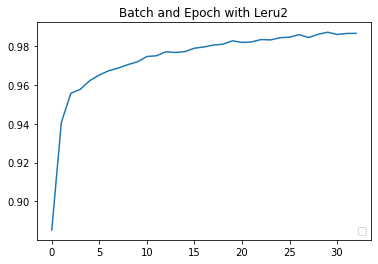

In [188]:
plt.plot(early_model.history['binary_accuracy'])
plt.title('Batch and Epoch with Leru2')
plt.legend(loc='lower right')
plt.show()

In [189]:
def leru_drop():

    model = Sequential()#Create our Model
    #First Layer
    model.add(Conv2D(16,(3,3),input_shape=(20,20,3),padding='same'))
    model.add(LeakyReLU(alpha=.2)) 
    model.add(Dropout(.2))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))

    #Second Layer
    model.add(Conv2D(32,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=.2)) 
    model.add(Dropout(.2))



    #Flatten
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['binary_accuracy'])
    return model

In [190]:
early_callback = EarlyStopping(monitor='binary_accuracy',patience= 3)
mod_7 = leru_model()
batch_size =32
epochs=50
early_model = mod_7.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,callbacks=[early_callback])

Train on 25600 samples
Epoch 1/50
25600/25600 [==============================] - 4s 145us/sample - loss: 0.2567 - binary_accuracy: 0.8940
Epoch 2/50
25600/25600 [==============================] - 3s 133us/sample - loss: 0.1407 - binary_accuracy: 0.9443
Epoch 3/50
25600/25600 [==============================] - 3s 132us/sample - loss: 0.1132 - binary_accuracy: 0.9576
Epoch 4/50
25600/25600 [==============================] - 3s 132us/sample - loss: 0.1021 - binary_accuracy: 0.9622
Epoch 5/50
25600/25600 [==============================] - 3s 135us/sample - loss: 0.0937 - binary_accuracy: 0.9642
Epoch 6/50
25600/25600 [==============================] - 3s 134us/sample - loss: 0.0837 - binary_accuracy: 0.9681
Epoch 7/50
25600/25600 [==============================] - 3s 133us/sample - loss: 0.0802 - binary_accuracy: 0.9692
Epoch 8/50
25600/25600 [==============================] - 3s 134us/sample - loss: 0.0773 - binary_accuracy: 0.9702
Epoch 9/50
25600/25600 [==============================] -

To avoid overfitting let`s try with dropping 20 percent after each layer, just like our goal dropping 20 percent helped to avoid overfitting a bit.

In [191]:
score_drop, acc_drop = mod_7.evaluate(x_test,y_test,verbose=0)
model_scores['Early and Drop'] = acc_drop

No handles with labels found to put in legend.


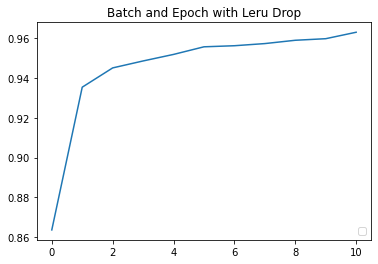

In [192]:
plt.plot(drop_model.history['binary_accuracy'])
plt.title('Batch and Epoch with Leru Drop')
plt.legend(loc='lower right')
plt.show()

In [ ]:
def sgd():

    model = Sequential()#Create our Model
    #First Layer
    model.add(Conv2D(16,(3,3),input_shape=(20,20,3),padding='same'))
    model.add(LeakyReLU(alpha=.2)) 
    model.add(Dropout(.2))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))

    #Second Layer
    model.add(Conv2D(32,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=.2)) 
    model.add(Dropout(.2))



    #Flatten
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer='SGD',metrics=['binary_accuracy'])
    return model

In [ ]:
mod_8 = sgd()
batch_size=32
epochs=50
sgd_model = mod_8.fit(x_train,y_train,batch_size=batch_size,epochs=epochs)

In [ ]:
score_sgd , acc_sgd = mod_8.evaluate(x_test,y_test,verbose=0)
model_scores['Sgd'] = acc_sgd

No handles with labels found to put in legend.


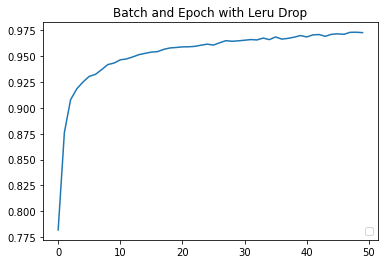

In [179]:
plt.plot(sgd_model.history['binary_accuracy'])
plt.title('Batch and Epoch with Leru Drop')
plt.legend(loc='lower right')
plt.show()

In [180]:
def sgd():

    model = Sequential()#Create our Model
    #First Layer
    model.add(Conv2D(16,(3,3),input_shape=(20,20,3),padding='same'))
    model.add(LeakyReLU(alpha=.2)) 
    model.add(Dropout(.2))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))

    #Second Layer
    model.add(Conv2D(32,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=.2)) 
    model.add(Dropout(.2))



    #Flatten
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='SGD',metrics=['binary_accuracy'])
    return model

In [181]:
mod_9 = sgd()
batch_size=32
epochs=50
sigmoid_mod = mod_9.fit(x_train,y_train,batch_size=batch_size,epochs=epochs)

Train on 25600 samples
Epoch 1/50
25600/25600 [==============================] - 5s 183us/sample - loss: 0.5235 - binary_accuracy: 0.7569
Epoch 2/50
25600/25600 [==============================] - 5s 190us/sample - loss: 0.3685 - binary_accuracy: 0.8217
Epoch 3/50
25600/25600 [==============================] - 5s 189us/sample - loss: 0.2841 - binary_accuracy: 0.8804
Epoch 4/50
25600/25600 [==============================] - 5s 187us/sample - loss: 0.2450 - binary_accuracy: 0.9028
Epoch 5/50
25600/25600 [==============================] - 5s 184us/sample - loss: 0.2218 - binary_accuracy: 0.9151
Epoch 6/50
25600/25600 [==============================] - 5s 184us/sample - loss: 0.2075 - binary_accuracy: 0.9190
Epoch 7/50
25600/25600 [==============================] - 5s 186us/sample - loss: 0.1970 - binary_accuracy: 0.9237
Epoch 8/50
25600/25600 [==============================] - 5s 185us/sample - loss: 0.1884 - binary_accuracy: 0.9273
Epoch 9/50
25600/25600 [==============================] -

Lastly I have tried to change optimizer to SGD and SGD with sigmoid activation function, these attemps did not perform well.

No handles with labels found to put in legend.


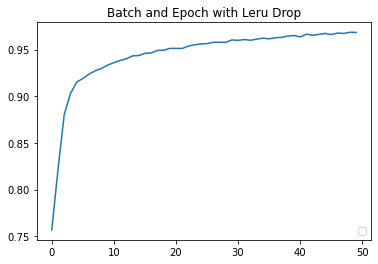

In [182]:
plt.plot(sigmoid_mod.history['binary_accuracy'])
plt.title('Batch and Epoch with Leru Drop')
plt.legend(loc='lower right')
plt.show()

In [184]:
score_sgd_s , acc_sgd_s = mod_9.evaluate(x_test,y_test,verbose=0)
model_scores['Sgd with Sigmoid'] = acc_sgd_s

In [226]:
df = pd.DataFrame(model_scores,index=[0])

In [239]:
from keras.preprocessing.image import ImageDataGenerator

In [254]:
datagen = ImageDataGenerator(rotation_range=20, zoom_range = 0.1,horizontal_flip=True)
datagen.fit(x_train)
mod2.fit_generator(datagen.flow(x_train,y_train,batch_size=32),
epochs=50,steps_per_epoch=x_train.shape[0]// batch_size,
validation_data =(x_test,y_test))

Epoch 1/50
800/800 [==============================] - 7s 9ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.0907 - binary_accuracy: 0.9658 - val_loss: 0.0789 - val_binary_accuracy: 0.9731
Epoch 2/50
800/800 [==============================] - 7s 9ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.0907 - binary_accuracy: 0.9659 - val_loss: 0.0765 - val_binary_accuracy: 0.9715
Epoch 3/50
800/800 [==============================] - 7s 9ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.0900 - binary_accuracy: 0.9666 - val_loss: 0.0819 - val_binary_accuracy: 0.9702
Epoch 4/50
800/800 [==============================] - 7s 9ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.0891 - binary_accuracy: 0.9659 - val_loss: 0.0862 - val_binary_accuracy: 0.9682
Epoch 5/50
800/800 [==============================] - 8s 9ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.0868 - binary_accuracy: 0.9673 - val_loss: 0.0741 - val_binary_accuracy: 0.9741
Epoch 6/50
800/800 [==============================

In [255]:
scoe_l, acc_l =mod2.evaluate(x_test,y_test,verbose=0)
print(acc_l)

0.9730469


To avoid overfitting lets build first 3 model again with data augmentation, which will distort the data according to our input on every batch only in Training.

In [294]:
df

,Base,Epoch,Batch1,Kernel,Kernel_2,Leru,Early,Early and Drop,Sgd,Sgd with Sigmoid
0,0.968359,0.96625,0.976484,0.973125,0.970469,0.975156,0.97625,0.973437,0.948438,0.969141


In [284]:
def leru_model_a():

    model = Sequential()#Create our Model
    #First Layer
    model.add(Conv2D(16,(3,3),input_shape=(20,20,3),padding='same'))
    model.add(LeakyReLU(alpha=.2)) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))

    #Second Layer
    model.add(Conv2D(32,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=.2)) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))



    #Flatten
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['binary_accuracy'])
    return model

In [289]:
final_callback = EarlyStopping(monitor='binary_accuracy',patience= 3)
final_1 = leru_model_a()
datagen = ImageDataGenerator(rotation_range=20, zoom_range = 0.1,horizontal_flip=True)
aug_1 =final_1.fit(datagen.flow(x_train,y_train,batch_size=32),
epochs=50,steps_per_epoch=x_train.shape[0]// 32,
validation_data =(x_test,y_test),callbacks=[final_callback])

Epoch 1/50
800/800 [==============================] - 8s 10ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.2624 - binary_accuracy: 0.8898 - val_loss: 0.1631 - val_binary_accuracy: 0.9348
Epoch 2/50
800/800 [==============================] - 10s 12ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.1614 - binary_accuracy: 0.9368 - val_loss: 0.1343 - val_binary_accuracy: 0.9455
Epoch 3/50
800/800 [==============================] - 8s 10ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.1479 - binary_accuracy: 0.9422 - val_loss: 0.1323 - val_binary_accuracy: 0.9495
Epoch 4/50
800/800 [==============================] - 8s 10ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.1326 - binary_accuracy: 0.9488 - val_loss: 0.1487 - val_binary_accuracy: 0.9389
Epoch 5/50
800/800 [==============================] - 8s 10ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.1314 - binary_accuracy: 0.9496 - val_loss: 0.1066 - val_binary_accuracy: 0.9605
Epoch 6/50
800/800 [========================

In [292]:
aug_score_1, aug_acc_1 =final_1.evaluate(x_test,y_test,verbose=0)
print(aug_score_1,aug_acc_1)
pred = final_1.predict(x_test)

0.07986506535089574 0.973125


In [295]:
def batch_final():
    model = Sequential()#Create our Model
    #First Layer
    model.add(Conv2D(16,(2,2),input_shape=(20,20,3),padding='same',activation='relu')) #first layer of our network
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))

    #Second Layer
    model.add(Conv2D(32,(2,2),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))



    #Flatten
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['binary_accuracy'])
    return model

In [296]:
final_2 = batch_final()
datagen = ImageDataGenerator(rotation_range=20, zoom_range = 0.1,horizontal_flip=True)
aug_2 =final_2.fit(datagen.flow(x_train,y_train,batch_size=32),
epochs=50,steps_per_epoch=x_train.shape[0]// 32,
validation_data =(x_test,y_test))

Epoch 1/50
800/800 [==============================] - 8s 10ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.3105 - binary_accuracy: 0.8691 - val_loss: 0.2124 - val_binary_accuracy: 0.9174
Epoch 2/50
800/800 [==============================] - 7s 9ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.1956 - binary_accuracy: 0.9227 - val_loss: 0.1668 - val_binary_accuracy: 0.9327
Epoch 3/50
800/800 [==============================] - 8s 9ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.1707 - binary_accuracy: 0.9325 - val_loss: 0.1617 - val_binary_accuracy: 0.9397
Epoch 4/50
800/800 [==============================] - 8s 10ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.1553 - binary_accuracy: 0.9386 - val_loss: 0.1399 - val_binary_accuracy: 0.9453
Epoch 5/50
800/800 [==============================] - 7s 9ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.1466 - binary_accuracy: 0.9417 - val_loss: 0.1515 - val_binary_accuracy: 0.9445
Epoch 6/50
800/800 [============================

In [332]:
aug_score_2, aug_acc_2 =final_2.evaluate(x_test,y_test,verbose=0)
print(aug_score_2,aug_acc_2)
pred2 = final_2.predict(x_test)

0.13274126434000208 0.9475


In [298]:
def leru_model_a():

    model = Sequential()#Create our Model
    #First Layer
    model.add(Conv2D(16,(3,3),input_shape=(20,20,3),padding='same'))
    model.add(LeakyReLU(alpha=.2)) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))

    #Second Layer
    model.add(Conv2D(32,(3,3),padding='same'))
    model.add(LeakyReLU(alpha=.2)) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))



    #Flatten
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['binary_accuracy'])
    return model

,Base,Epoch,Batch1,Kernel,Kernel_2,Leru,Early,Early and Drop,Sgd,Sgd with Sigmoid
0,0.968359,0.96625,0.976484,0.973125,0.970469,0.975156,0.97625,0.973437,0.948438,0.969141


In [299]:
final_3 = leru_model_a()
datagen = ImageDataGenerator(rotation_range=20, zoom_range = 0.1,horizontal_flip=True)
aug_3 =final_3.fit(datagen.flow(x_train,y_train,batch_size=32),
epochs=50,steps_per_epoch=x_train.shape[0]// 32,
validation_data =(x_test,y_test))

Epoch 1/50
800/800 [==============================] - 8s 10ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.2979 - binary_accuracy: 0.8715 - val_loss: 0.1983 - val_binary_accuracy: 0.9186
Epoch 2/50
800/800 [==============================] - 8s 10ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.1782 - binary_accuracy: 0.9300 - val_loss: 0.1533 - val_binary_accuracy: 0.9370
Epoch 3/50
800/800 [==============================] - 8s 10ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.1517 - binary_accuracy: 0.9427 - val_loss: 0.1214 - val_binary_accuracy: 0.9491
Epoch 4/50
800/800 [==============================] - 8s 10ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.1403 - binary_accuracy: 0.9460 - val_loss: 0.1148 - val_binary_accuracy: 0.9553
Epoch 5/50
800/800 [==============================] - 8s 10ms/step - batch: 399.5000 - size: 32.0000 - loss: 0.1328 - binary_accuracy: 0.9493 - val_loss: 0.1083 - val_binary_accuracy: 0.9592
Epoch 6/50
800/800 [=========================

In [331]:
aug_score_3, aug_acc_3 =final_3.evaluate(x_test,y_test,verbose=0)
print(aug_score_3,aug_acc_3)
pred3 = final_3.predict(x_test)

0.07738592236535624 0.9714062


In [342]:
accuracy["Batch Normal"] = acc_batch
accuracy["Leru Normal"] = acc_leru
accuracy["Early Normal"] = acc_early
accuracy["Batch Aug"] = aug_acc_2
accuracy["Leru Aug"] = aug_acc_3
accuracy["Early Aug"] = aug_acc_1

In [343]:
df1 =pd.DataFrame(accuracy,index=[0])

In [366]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

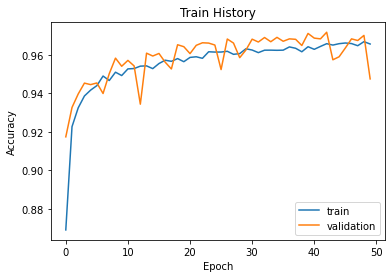

In [367]:
show_train_history(aug_2,'binary_accuracy','val_binary_accuracy')

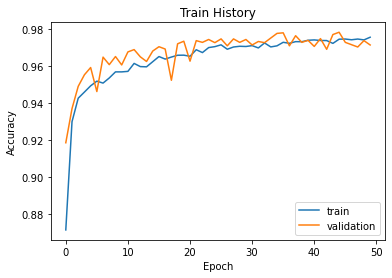

In [368]:
show_train_history(aug_3,'binary_accuracy','val_binary_accuracy')

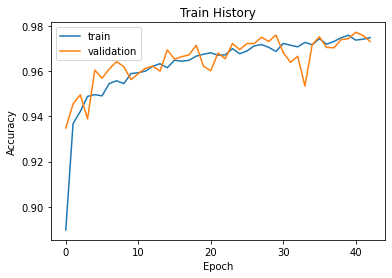

In [369]:
show_train_history(aug_1,'binary_accuracy','val_binary_accuracy')